In [94]:
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False # this to force autocompletion 

In [95]:
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from time import time
from sklearn.model_selection import train_test_split as sp
from sklearn.feature_extraction.text import CountVectorizer as vecto
from tensorflow import keras
from sklearn.metrics import confusion_matrix


In [96]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [97]:
z= zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/YouTube-Spam-Collection-v1.zip")
Psy=pd.read_csv(z.open("Youtube01-Psy.csv"))
KatyPerry  =pd.read_csv(z.open("Youtube02-KatyPerry.csv"))
LMFAQ =pd.read_csv(z.open("Youtube03-LMFAO.csv"))
Eminem =pd.read_csv(z.open("Youtube04-Eminem.csv"))
Shakira =pd.read_csv(z.open("Youtube05-Shakira.csv"))
frames = [Psy,LMFAQ,Eminem,Shakira,KatyPerry]
df = pd.concat(frames)
df.head(10)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1
5,LZQPQhLyRh9-wNRtlZDM90f1k0BrdVdJyN_YsaSwfxc,Jason Haddad,2013-11-26T02:55:11,"Hey, check out my new website!! This site is a...",1
6,z13lfzdo5vmdi1cm123te5uz2mqig1brz04,ferleck ferles,2013-11-27T21:39:24,Subscribe to my channel ﻿,1
7,z122wfnzgt30fhubn04cdn3xfx2mxzngsl40k,Bob Kanowski,2013-11-28T12:33:27,i turned it on mute as soon is i came on i jus...,0
8,z13ttt1jcraqexk2o234ghbgzxymz1zzi04,Cony,2013-11-28T16:01:47,You should check my channel for Funny VIDEOS!!﻿,1
9,z12avveb4xqiirsix04chxviiljryduwxg0,BeBe Burkey,2013-11-28T16:30:13,and u should.d check my channel and tell me wh...,1


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 349
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1956 non-null   object
 1   AUTHOR      1956 non-null   object
 2   DATE        1711 non-null   object
 3   CONTENT     1956 non-null   object
 4   CLASS       1956 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 91.7+ KB


In [99]:
df.shape

(1956, 5)

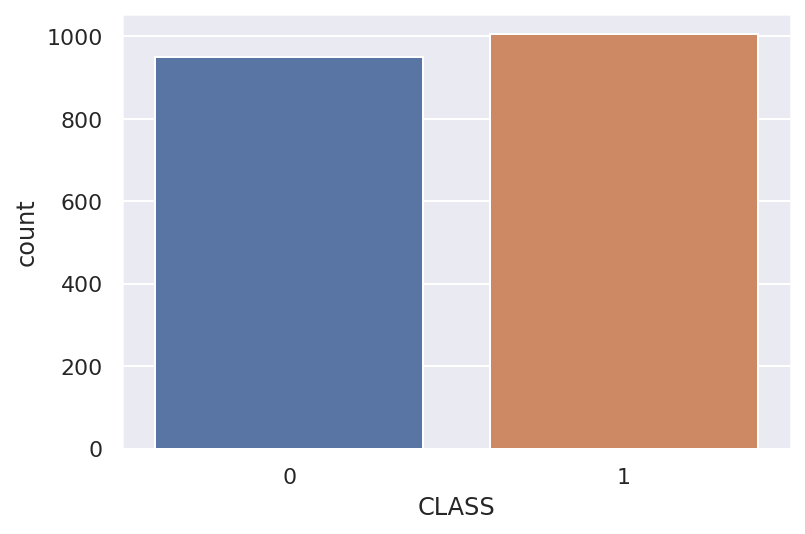

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.countplot(df.CLASS)
plt.show()

In [101]:
df['word_length'] = df['CONTENT'].apply(lambda x:len(x.split()))

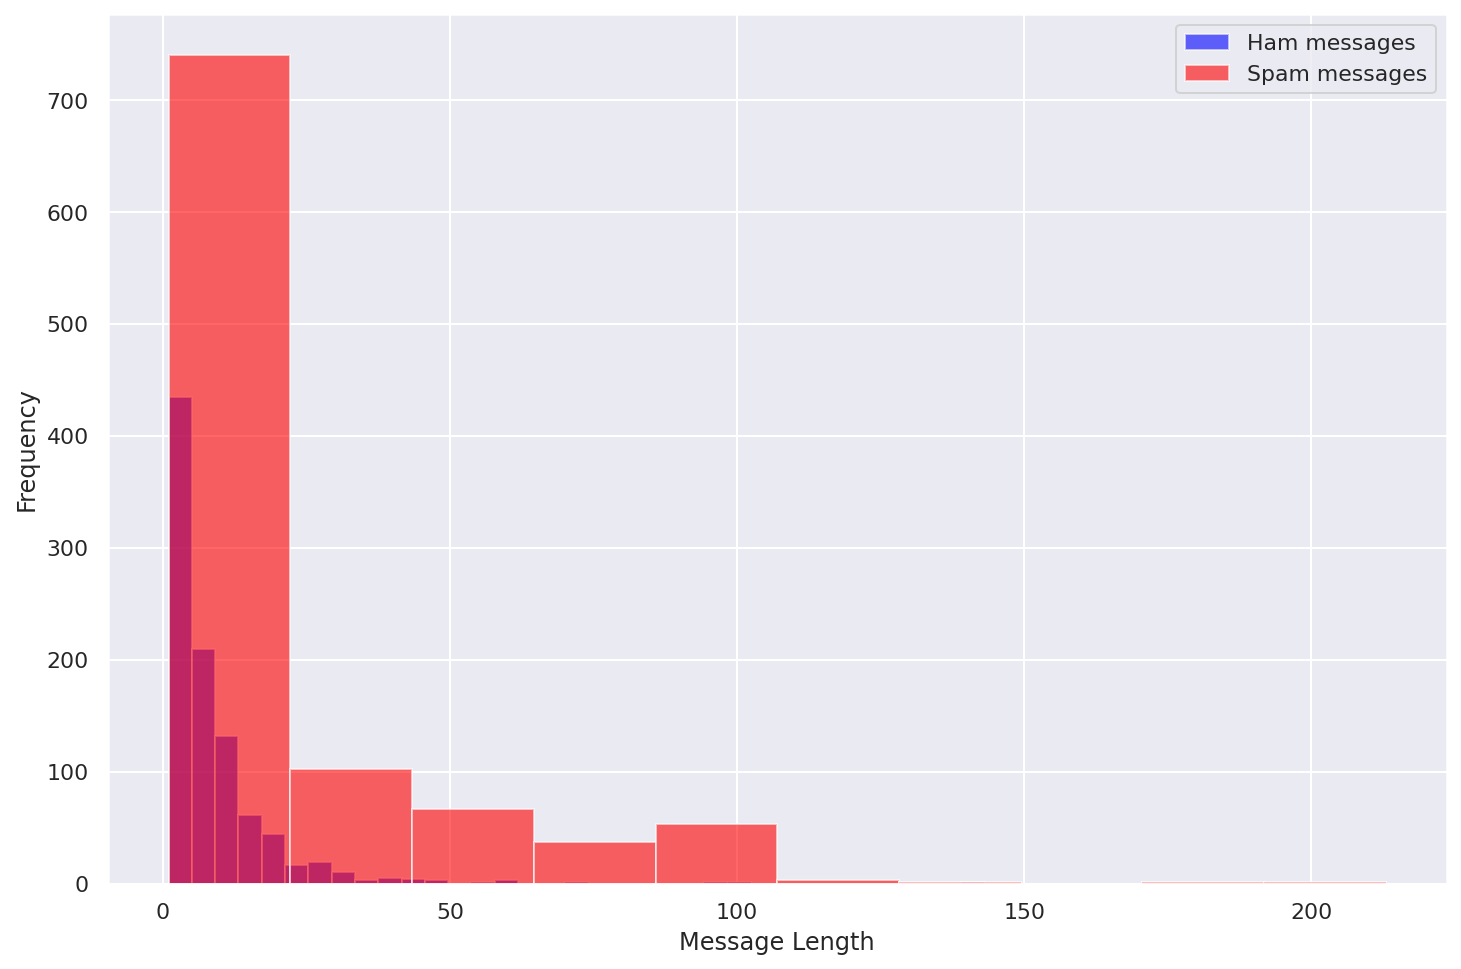

In [102]:
plt.figure(figsize=(12, 8))

df[df.CLASS==0].word_length.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
df[df.CLASS == 1].word_length.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")
plt.show()

In [103]:
df.groupby('CLASS').mean()

,word_length
CLASS,
0,9.100946
1,21.714428


In [104]:
df[df.CLASS == 0].describe()

,CLASS,word_length
count,951.0,951.000000
mean,0.0,9.100946
std,0.0,10.432051
min,0.0,1.000000
25%,0.0,3.000000
50%,0.0,6.000000
75%,0.0,12.000000
max,0.0,143.000000


In [105]:
df[df.CLASS == 1].describe()

,CLASS,word_length
count,1005.0,1005.000000
mean,1.0,21.714428
std,0.0,26.878342
min,1.0,1.000000
25%,1.0,6.000000
50%,1.0,10.000000
75%,1.0,23.000000
max,1.0,213.000000


In [106]:
pip install text-hammer

In [107]:
import text_hammer as th

In [108]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_stopwords(x))
#     df[column] = df[column].progress_apply(lambda x:th.spelling_correction(x))
  
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

In [109]:
cleaned_df = text_preprocessing(df, "CONTENT")

  0%|          | 0/1956 [00:00<?, ?it/s]

  0%|          | 0/1956 [00:00<?, ?it/s]

  0%|          | 0/1956 [00:00<?, ?it/s]

  0%|          | 0/1956 [00:00<?, ?it/s]

  0%|          | 0/1956 [00:00<?, ?it/s]

  0%|          | 0/1956 [00:00<?, ?it/s]

  0%|          | 0/1956 [00:00<?, ?it/s]

  0%|          | 0/1956 [00:00<?, ?it/s]

In [110]:
cleaned_df.CONTENT


0                   huh check youtube channel kobyoshi02
1      hey guy check new channel vid monkey monkey wh...
2                                         test murdevcom
3                         shake sexy ass channel enjoy _
4                                watchvvtarggvgtwq check
                             ...                        
345    song mean thank sooooooooooooooooooooooooooooo...
346                                                    3
347    katy perry decio cabelo decio hair 60 year age...
348    honestly speak taylor swift adele lile modern ...
349                         go reach billion katy taylor
Name: CONTENT, Length: 1956, dtype: object

In [111]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [112]:
import nltk



### Calculating the word frequency by using nltk
words_list = []
for sentence in cleaned_df.CONTENT:
    words_list.extend(nltk.word_tokenize(sentence))
freq_dist = nltk.FreqDist(words_list)
freq_dist.most_common(20)
# freq_dist.keys()

[('check', 568),
 ('video', 376),
 ('song', 326),
 ('like', 263),
 ('subscribe', 234),
 ('youtube', 220),
 ('love', 213),
 ('channel', 195),
 ('i', 167),
 ('m', 154),
 ('music', 149),
 ('good', 146),
 ('not', 141),
 ('guy', 133),
 ('thank', 127),
 ('new', 125),
 ('view', 119),
 ('comment', 103),
 ('do', 94),
 ('people', 89)]

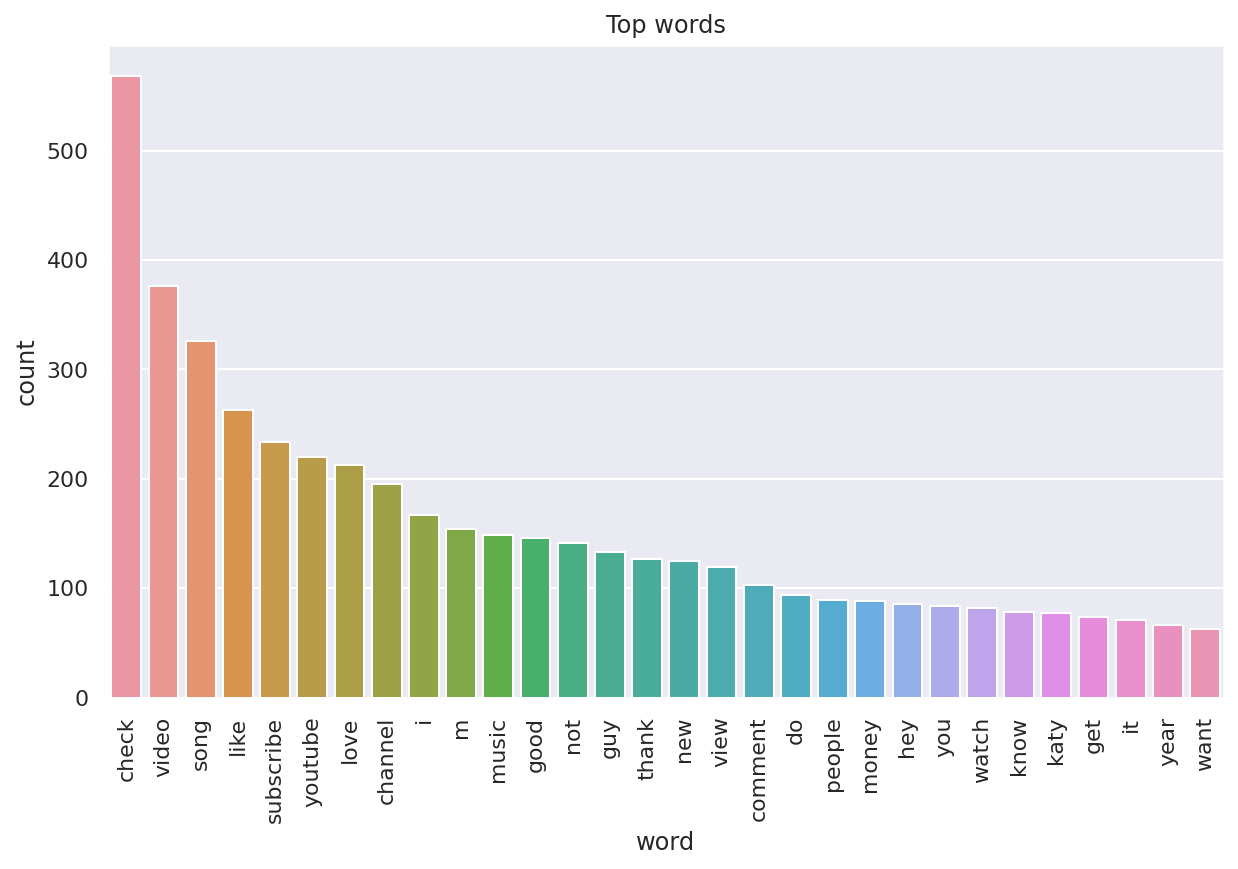

In [113]:
temp = pd.DataFrame(freq_dist.most_common(30),  columns=['word', 'count'])
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=temp, ax=ax)
plt.title("Top words")
plt.xticks(rotation='vertical');

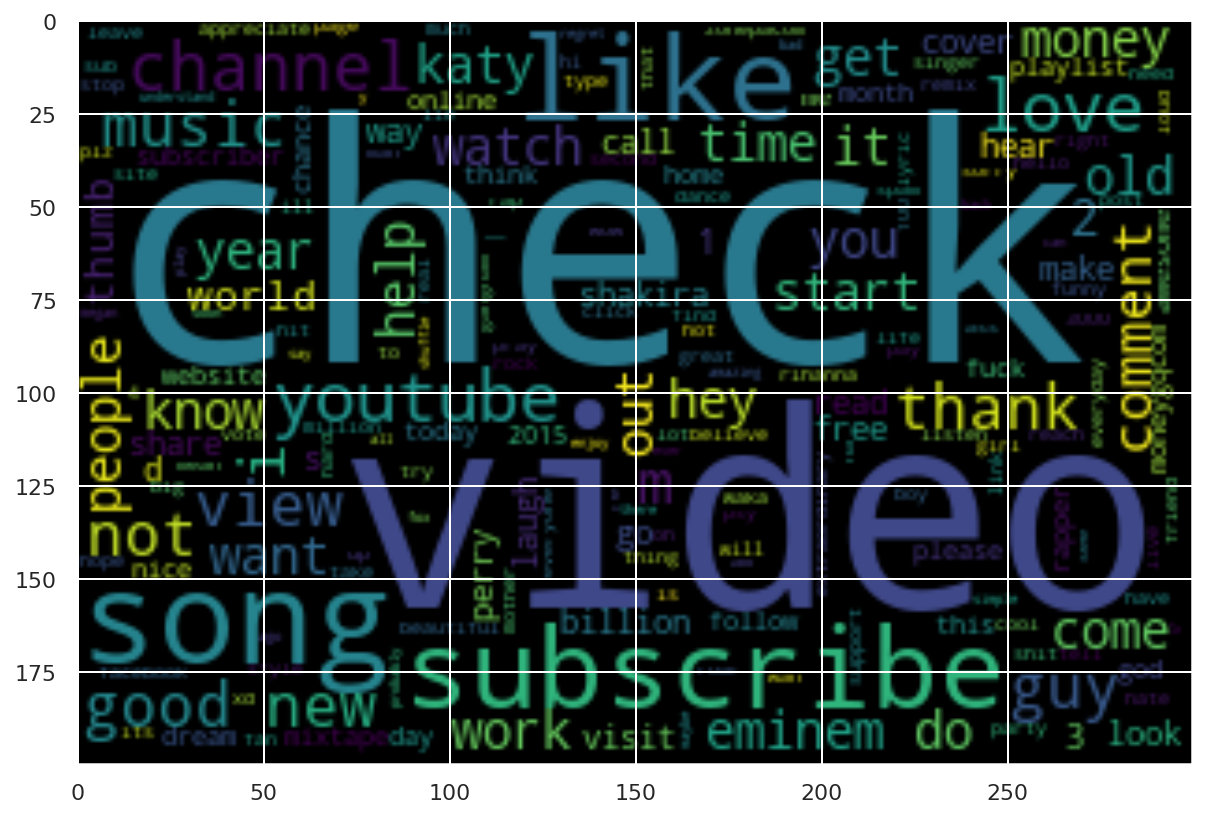

In [114]:
### Creating wordcloud
from wordcloud import WordCloud
import wordcloud
# creation of wordcloud
wcloud_fig = WordCloud( stopwords=set(wordcloud.STOPWORDS),
                      colormap='viridis', width=300, height=200).generate_from_frequencies(freq_dist)

# plotting the wordcloud
plt.figure(figsize=(10,7), frameon=True)

plt.imshow(wcloud_fig, interpolation  = 'bilinear')
plt.show()

In [115]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(cleaned_df.CONTENT, cleaned_df.CLASS, test_size = 0.2, stratify = cleaned_df.CLASS
                                                 ,random_state = 42)

In [116]:
from keras.preprocessing.text import Tokenizer
num_words = 10000 # this means 15000 unique words can be taken 
tokenizer=Tokenizer(num_words,lower=True)
df_total = pd.concat([X_train, X_test], axis = 0)
tokenizer.fit_on_texts(df_total)

In [117]:
len(tokenizer.word_index) 

3714

In [118]:
cleaned_df.word_length.max()

213

In [119]:
from keras.preprocessing.sequence import pad_sequences

X_train_ =tokenizer.texts_to_sequences(X_train)
X_train_pad=pad_sequences(X_train_,maxlen=171,padding='post')
X_test_ = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_, maxlen = 171, padding = 'post')

In [120]:
print(X_train_pad.shape,X_test_pad.shape)

(1564, 171) (392, 171)


In [121]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional,SimpleRNN,GRU
import tensorflow
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,CuDNNGRU
from tensorflow.keras.layers import Dropout

#bi-lstm starts here

In [122]:
EMBEDDING_DIM = 100 # this means the embedding layer will create  a vector in 100 dimension
model = Sequential()
model.add(Embedding(input_dim = num_words,# the whole vocabulary size 
                          output_dim = EMBEDDING_DIM, # vector space dimension
                          input_length= X_train_pad.shape[1] # max_len of text sequence
                          ))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(400,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100,return_sequences=False)))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam',metrics = 'accuracy')

In [123]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 171, 100)          1000000   
                                                                 
 dropout_18 (Dropout)        (None, 171, 100)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 171, 800)         1603200   
 nal)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 171, 800)          0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 171, 400)         1601600   
 nal)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 171, 400)         

In [124]:


from keras.callbacks import EarlyStopping, ModelCheckpoint



In [125]:
history_embedding = model.fit(X_train_pad,y_train, epochs = 20, batch_size = 128, validation_data=(X_test_pad, y_test),verbose = 1 )

Epoch 1/20
13/13 [==============================] - 294s 17s/step - loss: 0.6597 - accuracy: 0.5780 - val_loss: 0.5892 - val_accuracy: 0.6429
Epoch 2/20
13/13 [==============================] - 202s 16s/step - loss: 0.4212 - accuracy: 0.8075 - val_loss: 0.3401 - val_accuracy: 0.8597
Epoch 3/20
13/13 [==============================] - 192s 15s/step - loss: 0.2132 - accuracy: 0.9169 - val_loss: 0.3283 - val_accuracy: 0.8724
Epoch 4/20
13/13 [==============================] - 200s 15s/step - loss: 0.1095 - accuracy: 0.9642 - val_loss: 0.3226 - val_accuracy: 0.8827
Epoch 5/20
13/13 [==============================] - 197s 15s/step - loss: 0.0685 - accuracy: 0.9840 - val_loss: 0.2998 - val_accuracy: 0.9031
Epoch 6/20
13/13 [==============================] - 196s 15s/step - loss: 0.0430 - accuracy: 0.9885 - val_loss: 0.3485 - val_accuracy: 0.8878
Epoch 7/20
13/13 [==============================] - 198s 15s/step - loss: 0.0213 - accuracy: 0.9955 - val_loss: 0.4587 - val_accuracy: 0.8750
Epoch 

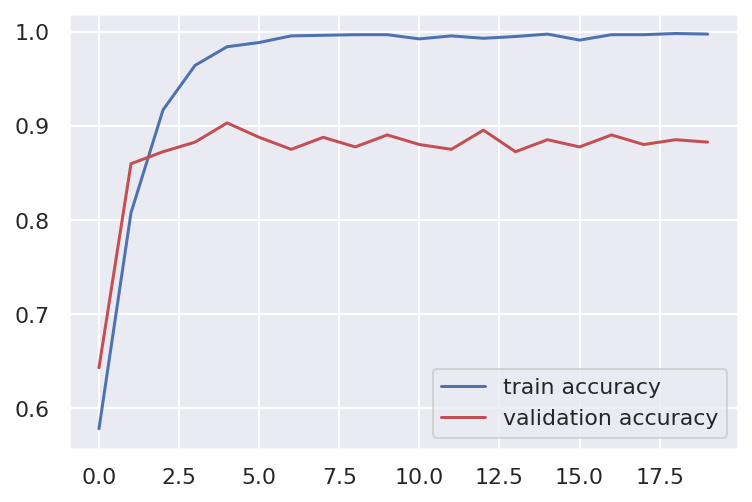

In [126]:
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [127]:
model.evaluate(X_test_pad, y_test)

13/13 [==============================] - 28s 2s/step - loss: 0.5824 - accuracy: 0.8827


[0.5824429392814636, 0.8826530575752258]

In [128]:
y_pred=model.predict(X_test_pad)
y_pred=y_pred.flatten()


In [129]:
import numpy as np


y_pred=np.where(y_pred>0.5,1,0)
y_pred

array([0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,

In [130]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
cm

array([[176,  15],
       [ 31, 170]])

Text(30.5, 0.5, 'Truth')

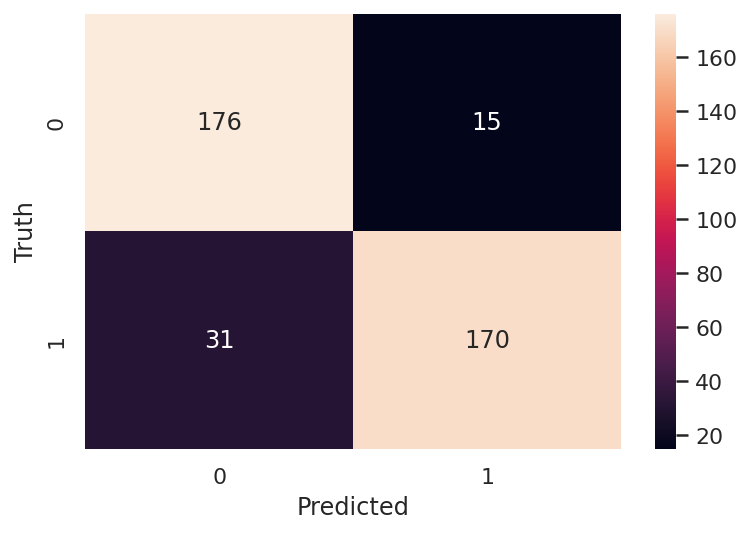

In [131]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [132]:
from sklearn import metrics
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       207
           1       0.85      0.92      0.88       185

    accuracy                           0.88       392
   macro avg       0.88      0.88      0.88       392
weighted avg       0.89      0.88      0.88       392



#bi-lstm ends

#rnn starts here

In [133]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-100')

In [134]:
vector_size = 100
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape

for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero 
        if word in glove_gensim.wv.vocab:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

In [135]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional,SimpleRNN

In [136]:
EMBEDDING_DIM = 100 # this means the embedding layer will create  a vector in 100 dimension
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim = num_words,# the whole vocabulary size 
                          output_dim = EMBEDDING_DIM, # vector space dimension
                          input_length= X_train_pad.shape[1], # max_len of text sequence
                          weights = [gensim_weight_matrix],trainable = False))
model_rnn.add(Dropout(0.2))

model_rnn.add(SimpleRNN(100,return_sequences=True))
model_rnn.add(Dropout(0.2))

model_rnn.add(SimpleRNN(200,return_sequences=True))
model_rnn.add(Dropout(0.2))

model_rnn.add(SimpleRNN(100,return_sequences=True))
model_rnn.add(Dense(1, activation = 'sigmoid'))
model_rnn.compile(loss = 'binary_crossentropy', optimizer = 'adam',metrics = 'accuracy')

In [137]:
model_rnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 171, 100)          1000000   
                                                                 
 dropout_21 (Dropout)        (None, 171, 100)          0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 171, 100)          20100     
                                                                 
 dropout_22 (Dropout)        (None, 171, 100)          0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 171, 200)          60200     
                                                                 
 dropout_23 (Dropout)        (None, 171, 200)          0         
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 171, 100)         

In [138]:
#EarlyStopping and ModelCheckpoint

from keras.callbacks import EarlyStopping, ModelCheckpoint




In [140]:
history_embedding = model_rnn.fit(X_train_pad,y_train, epochs = 5, batch_size = 128, validation_data=(X_test_pad, y_test),verbose = 1 )

Epoch 1/5
13/13 [==============================] - 11s 841ms/step - loss: 0.5123 - accuracy: 0.7811 - val_loss: 0.4632 - val_accuracy: 0.8101
Epoch 2/5
13/13 [==============================] - 11s 815ms/step - loss: 0.4894 - accuracy: 0.7881 - val_loss: 0.4161 - val_accuracy: 0.8305
Epoch 3/5
13/13 [==============================] - 11s 842ms/step - loss: 0.4603 - accuracy: 0.8052 - val_loss: 0.4807 - val_accuracy: 0.7569
Epoch 4/5
13/13 [==============================] - 11s 874ms/step - loss: 0.5201 - accuracy: 0.7740 - val_loss: 0.5202 - val_accuracy: 0.7635
Epoch 5/5
13/13 [==============================] - 11s 825ms/step - loss: 0.5317 - accuracy: 0.7563 - val_loss: 0.5128 - val_accuracy: 0.7658


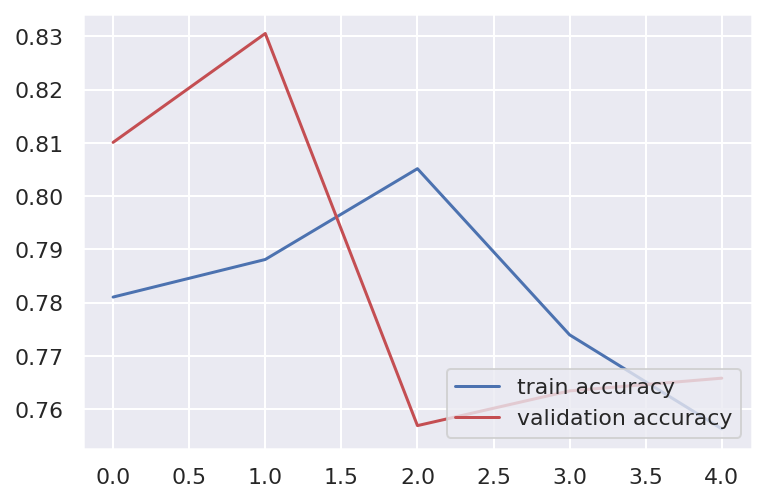

In [141]:
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [142]:
model_rnn.evaluate(X_test_pad, y_test)

13/13 [==============================] - 1s 61ms/step - loss: 0.5128 - accuracy: 0.7658


[0.5127788782119751, 0.7658432126045227]

In [143]:
y_pred=model.predict(X_test_pad)
y_pred=y_pred.flatten()

In [144]:

import numpy as np


y_pred=np.where(y_pred>0.5,1,0)
y_pred


from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
cm

array([[176,  15],
       [ 31, 170]])

Text(30.5, 0.5, 'Truth')

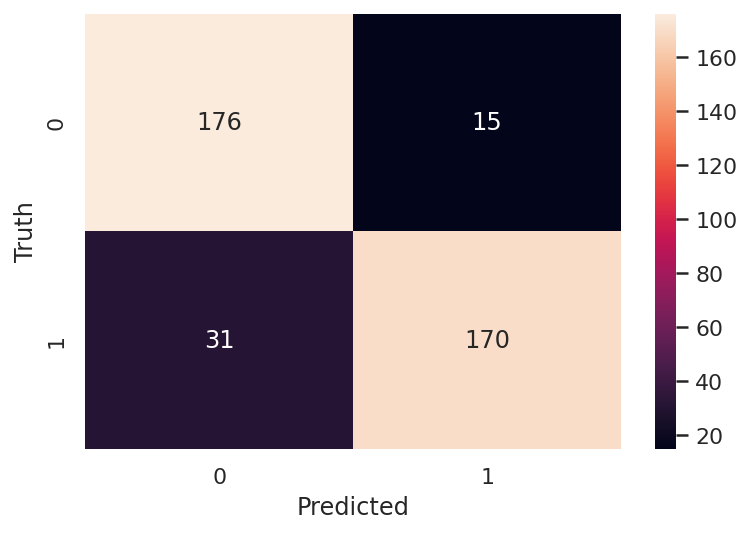

In [145]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [146]:
from sklearn import metrics
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       207
           1       0.85      0.92      0.88       185

    accuracy                           0.88       392
   macro avg       0.88      0.88      0.88       392
weighted avg       0.89      0.88      0.88       392



#lstm starts here

In [147]:
EMBEDDING_DIM = 100 # this means the embedding layer will create  a vector in 100 dimension
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = num_words,# the whole vocabulary size 
                          output_dim = EMBEDDING_DIM, # vector space dimension
                          input_length= X_train_pad.shape[1], # max_len of text sequence
                          weights = [gensim_weight_matrix],trainable = False))
model_rnn.add(Dropout(0.2))
model_lstm.add(LSTM(200,return_sequences=True))

model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(200,return_sequences=True))

model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(100,return_sequences=False))

model_lstm.add(Dense(1, activation = 'sigmoid'))
model_lstm.compile(loss = 'binary_crossentropy', optimizer = 'adam',metrics = 'accuracy')

In [148]:
model_lstm.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 171, 100)          1000000   
                                                                 
 lstm_12 (LSTM)              (None, 171, 200)          240800    
                                                                 
 dropout_25 (Dropout)        (None, 171, 200)          0         
                                                                 
 lstm_13 (LSTM)              (None, 171, 200)          320800    
                                                                 
 dropout_26 (Dropout)        (None, 171, 200)          0         
                                                                 
 lstm_14 (LSTM)              (None, 100)               120400    
                                                                 
 dense_8 (Dense)             (None, 1)                

In [149]:
#EarlyStopping and ModelCheckpoint

from keras.callbacks import EarlyStopping, ModelCheckpoint




In [150]:
history_embedding = model_lstm.fit(X_train_pad,y_train, epochs = 5, batch_size = 128, validation_data=(X_test_pad, y_test),verbose = 1  )

Epoch 1/5
13/13 [==============================] - 55s 4s/step - loss: 0.6944 - accuracy: 0.5090 - val_loss: 0.6929 - val_accuracy: 0.5128
Epoch 2/5
13/13 [==============================] - 47s 4s/step - loss: 0.6929 - accuracy: 0.5141 - val_loss: 0.6929 - val_accuracy: 0.5128
Epoch 3/5
13/13 [==============================] - 46s 4s/step - loss: 0.6930 - accuracy: 0.5141 - val_loss: 0.6928 - val_accuracy: 0.5128
Epoch 4/5
13/13 [==============================] - 46s 4s/step - loss: 0.6938 - accuracy: 0.5141 - val_loss: 0.6929 - val_accuracy: 0.5128
Epoch 5/5
13/13 [==============================] - 44s 3s/step - loss: 0.6930 - accuracy: 0.5141 - val_loss: 0.6928 - val_accuracy: 0.5128


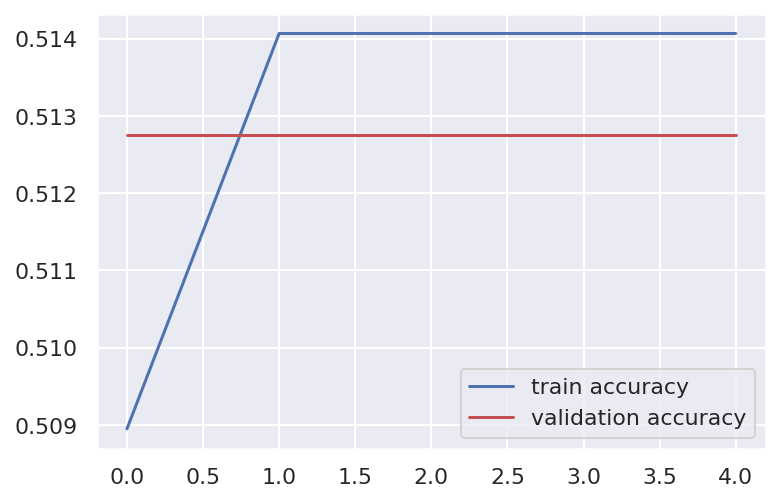

In [151]:
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(30.5, 0.5, 'Truth')

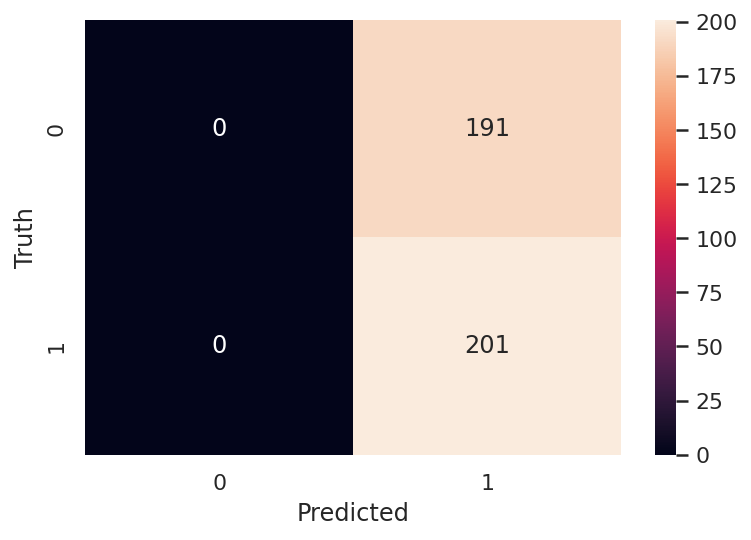

In [152]:
y_pred=model_lstm.predict(X_test_pad)
y_pred=y_pred.flatten()
import numpy as np


y_pred=np.where(y_pred>0.5,1,0)
y_pred


from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)


from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [153]:
from sklearn import metrics
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.51      0.68       392

    accuracy                           0.51       392
   macro avg       0.50      0.26      0.34       392
weighted avg       1.00      0.51      0.68       392



In [154]:
model_lstm.evaluate(X_test_pad, y_test)

13/13 [==============================] - 4s 337ms/step - loss: 0.6928 - accuracy: 0.5128


[0.6928373575210571, 0.5127550959587097]

#GRU starts here

In [155]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM,GRU
from keras.layers import Dense,Bidirectional

In [156]:
EMBEDDING_DIM = 100 # this means the embedding layer will create  a vector in 100 dimension
model_GRU = Sequential()
model_GRU.add(Embedding(input_dim = num_words,# the whole vocabulary size 
                          output_dim = EMBEDDING_DIM, # vector space dimension
                          input_length= X_train_pad.shape[1], # max_len of text sequence
                          weights = [gensim_weight_matrix],trainable = False))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(100,return_sequences=True))

model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(200,return_sequences=True))

model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(100,return_sequences=False))

model_GRU.add(Dense(1, activation = 'sigmoid'))
model_GRU.compile(loss = 'binary_crossentropy', optimizer = 'adam',metrics = 'accuracy')

In [157]:
model_GRU.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 171, 100)          1000000   
                                                                 
 dropout_27 (Dropout)        (None, 171, 100)          0         
                                                                 
 gru_3 (GRU)                 (None, 171, 100)          60600     
                                                                 
 dropout_28 (Dropout)        (None, 171, 100)          0         
                                                                 
 gru_4 (GRU)                 (None, 171, 200)          181200    
                                                                 
 dropout_29 (Dropout)        (None, 171, 200)          0         
                                                                 
 gru_5 (GRU)                 (None, 100)             

In [158]:
#EarlyStopping and ModelCheckpoint

from keras.callbacks import EarlyStopping, ModelCheckpoint


#es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
#mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)
#, callbacks= [es, mc] 

In [159]:
history_embedding = model_GRU.fit(X_train_pad,y_train, epochs = 5, batch_size = 128, validation_data=(X_test_pad, y_test),verbose = 1 )

Epoch 1/5
13/13 [==============================] - 37s 2s/step - loss: 0.6939 - accuracy: 0.5026 - val_loss: 0.6928 - val_accuracy: 0.5128
Epoch 2/5
13/13 [==============================] - 29s 2s/step - loss: 0.6930 - accuracy: 0.5141 - val_loss: 0.6928 - val_accuracy: 0.5128
Epoch 3/5
13/13 [==============================] - 29s 2s/step - loss: 0.6931 - accuracy: 0.5141 - val_loss: 0.6928 - val_accuracy: 0.5128
Epoch 4/5
13/13 [==============================] - 28s 2s/step - loss: 0.6930 - accuracy: 0.5141 - val_loss: 0.6928 - val_accuracy: 0.5128
Epoch 5/5
13/13 [==============================] - 29s 2s/step - loss: 0.6927 - accuracy: 0.5141 - val_loss: 0.6928 - val_accuracy: 0.5128


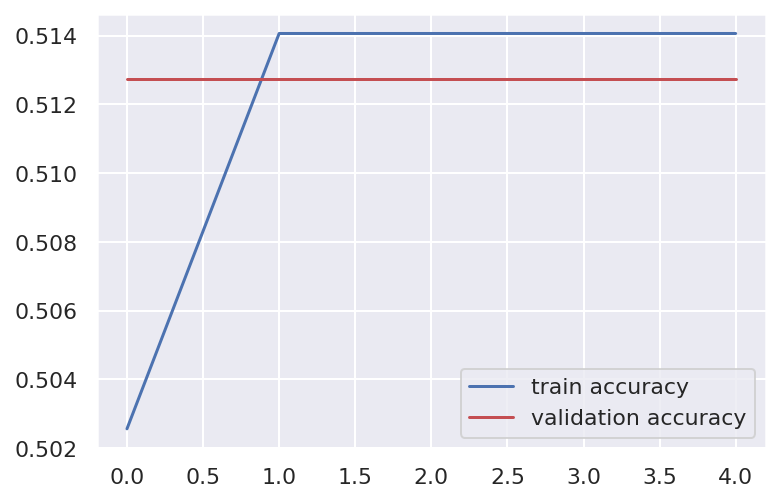

In [160]:
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(30.5, 0.5, 'Truth')

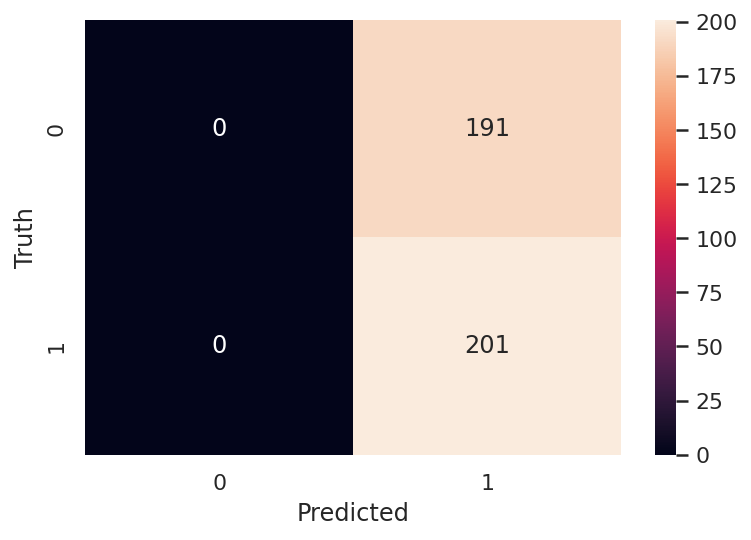

In [161]:
y_pred=model_GRU.predict(X_test_pad)
y_pred=y_pred.flatten()
import numpy as np


y_pred=np.where(y_pred>0.5,1,0)
y_pred


from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)


from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [162]:
from sklearn import metrics
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.51      0.68       392

    accuracy                           0.51       392
   macro avg       0.50      0.26      0.34       392
weighted avg       1.00      0.51      0.68       392



In [163]:
model_GRU.evaluate(X_test_pad, y_test)

13/13 [==============================] - 3s 195ms/step - loss: 0.6928 - accuracy: 0.5128


[0.6928408145904541, 0.5127550959587097]